In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from abtem import *

# Temperature effects with frozen phonons

The frozen phonon approximation is a simple if somewhat brute force approach to numerically simulate the effects of thermal vibrations in the specimen. The image or diffraction pattern is the intensity averaged over several different configurations of atoms with different random offsets. This type of scattering may be referred to as thermal diffuse scattering or simply TDS.

We will simulate Strontium Titanate [100] with TDS. In order, to observe visible Kikuchi lines, the sample needs a certain thickness, hence we repeat the unit cell 30 times along the z-direction.

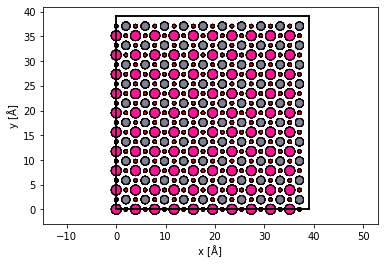

In [3]:
atoms = read('srtio3.cif')

atoms *= (10, 10, 30)

show_atoms(atoms)

The `FrozenPhonon` class generates offsets using a random number generator with a Gaussian distribution (equivalent to the Einstein model of the density of states for phonons). The standard deviation of the Gaussian distribution should be provided for each element as a dictionary.

In [11]:
frozen_phonons = FrozenPhonons(atoms, 1, {'Sr' : .1, 'Ti' : .1, 'O' : .1}, seed=1)

Below, we generate and show one of the frozen phonon configurations.

In [ ]:
atoms_conf = next(iter(frozen_phonons))

show_atoms(atoms_conf)

In [5]:
potential = Potential(frozen_phonons, sampling=.05)

potential.grid.snap_to_power(2)

The ETA after the first TDS configuration is overestimated by an order of magnitude, since the cache of potential integrals is getting filled.

In [6]:
from abtem.waves import PlaneWave

wave = PlaneWave(energy=300e3, device='cpu')

exit_wave = wave.multislice(potential)

In [7]:
exit_wave.array.shape

(1, 1024, 1024)

In [8]:
patterns = exit_wave.diffraction_pattern()

patterns.mean(0).array.shape

(512, 512)

In [9]:
potential.get_integrator(38)[0].cache._misses

1610

(<matplotlib.axes._subplots.AxesSubplot at 0x1321c66c18>,
 <matplotlib.image.AxesImage at 0x132227d710>)

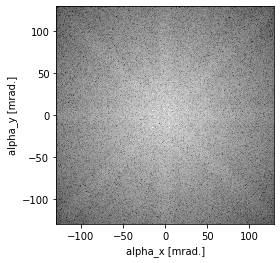

In [10]:
patterns[0].show(log_scale=True, vmax=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x131f73ac88>,
 <matplotlib.image.AxesImage at 0x131f89b5c0>)

/Users/jacobmadsen/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


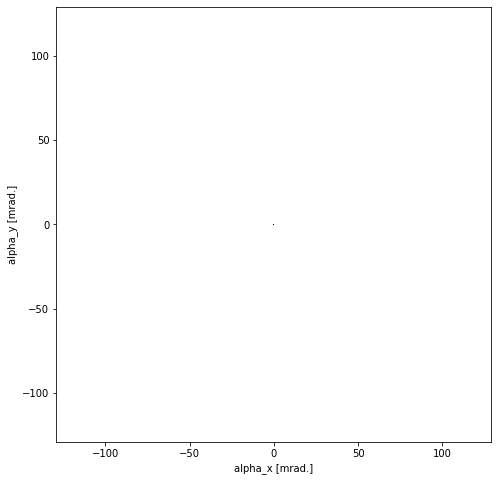

In [35]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
patterns.mean(0).show(log_scale=True, vmax=15, cmap='inferno', ax=ax)

#ax.axis('off')

#ax.set_xlim([-.15,.15])
#ax.set_ylim([-.15,.15])

## STEM with TDS

Simulating (4D)-STEM with TDS is no different than without, 

In [12]:
%load_ext autoreload
%autoreload 2

from ase.io import read
from abtem.scan import LineScan
from abtem.detect import AnnularDetector
from abtem.waves import Probe
from abtem.measure import Measurement
from abtem.potentials import Potential
from abtem.temperature import FrozenPhonons

atoms = read('graphene.cif') * (3, 2, 1)
atoms.center(vacuum=3,axis=2)

potential = Potential(FrozenPhonons(atoms, 5, {'C':.2}, seed=7), sampling=.02)

linescan = LineScan(start=[4.06, 0], end=[4.06, 4.06], gpts=10)

probe = Probe(energy=300e3, semiangle_cutoff=.03, focal_spread=60, defocus=50, device='cpu')
haadf = AnnularDetector(inner=.09, outer=.2)

#potential.show(scans=linescan)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
measurements = probe.scan(linescan, [haadf], potential, max_batch=1, pbar=True)

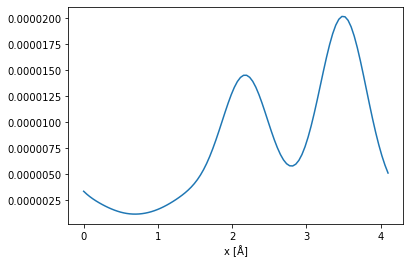

In [20]:
#ax=Measurement.read('linescan.hdf5').show()
measurements[haadf].show()
#print(ax)

In [26]:
from tqdm.notebook import tqdm
import time

pbar1 = tqdm(total=10)
pbar2 = tqdm(total=10)

for i in range(10):
    time.sleep(.1)
    pbar1.update(1)
    for j in range(10):
        time.sleep(.1)
        pbar2.update(1)
    pbar2.reset()
